# Different sources for Airport locations

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import geopandas


import numpy as np

import shapely.wkt

import osmnx as ox

ox.settings.log_console=True

## WorldBank Data

https://datacatalog.worldbank.org/search/dataset/0038117/Global-Airports

Unclear what "Seats" is referring to.

In [5]:
df_worldbank = pd.read_csv('airport_volume_airport_locations.csv')
df_worldbank = df_worldbank[df_worldbank['Country Name'] == "Tanzania"].sort_values('TotalSeats')

In [6]:
df_worldbank

,Orig,Name,TotalSeats,Country Name,Airport1Latitude,Airport1Longitude
1652,BKZ,Bukoba,259.980,Tanzania,-1.3000,31.799999
1656,MYW,Mtwara,1871.856,Tanzania,-10.3389,40.193600
1657,TKQ,Kigoma,4800.964,Tanzania,-4.8850,29.670000
1655,MWZ,Mwanza,12730.354,Tanzania,-2.4447,32.928101
1654,JRO,Kilimanjaro International,327618.130,Tanzania,-3.4278,37.072201
1658,ZNZ,Zanzibar International,505392.454,Tanzania,-6.2192,39.221901
1653,DAR,Julius Nyerere International,985142.214,Tanzania,-6.8753,39.201900


In [7]:
gdf_worldbank = geopandas.GeoDataFrame(
    df_worldbank, geometry = geopandas.points_from_xy(df_worldbank.Airport1Longitude, df_worldbank.Airport1Latitude))

## OurAirports

Based on OSM and other citizen sience sources.

https://ourairports.com/help/

"large_aiport" seems to catch A LOT more for tanzania that whay you would expect.

In [8]:
df_ourairports = pd.read_csv('airports.csv')

In [9]:
dfx = df_ourairports[(df_ourairports['iso_country'] == 'TZ')]
gdfx = geopandas.GeoDataFrame(
    dfx, geometry = geopandas.points_from_xy(dfx.longitude_deg, dfx.latitude_deg))


<AxesSubplot: >

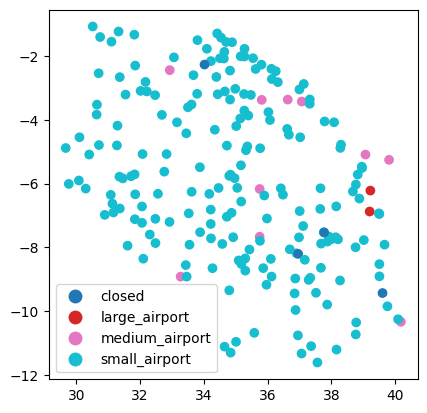

In [10]:
gdfx.plot(column='type', legend=True)

In [11]:
dfx = df_ourairports[(df_ourairports['iso_country'] == 'TZ') & (df_ourairports['type'] == 'large_airport')]

gdf_ourairports = geopandas.GeoDataFrame(
    dfx, geometry = geopandas.points_from_xy(dfx.longitude_deg, dfx.latitude_deg))

## GeoFabrik

In [12]:
# geofabrik
gdf_geofabrik = geopandas.read_file('/Users/jona/htdocs/MARS/data-hub/input/data/geofabrik/gis_osm_transport_a_free_1.shp')

In [13]:
gdf_geofabrik_a = gdf_geofabrik[gdf_geofabrik['fclass'] == 'airport'].copy()

In [14]:
gdf_geofabrik_a['geometry'] = gdf_geofabrik_a['geometry'].to_crs('+proj=cea').centroid.to_crs(gdf_geofabrik_a.crs)

## OpenStreetMap API

In [15]:
# TZ convex hull
tza = shapely.wkt.loads('POLYGON((36.51663051180202 -11.76400833641038,34.96148292189685 -11.57459896625327,34.96058197176314 -11.57433910112481,31.17774355463043 -8.599754824872136,29.72620481349243 -6.245866261163819,29.72511552786495 -6.24409782337949,29.72380939573032 -6.241814222429691,29.7230927952378 -6.239093880200518,29.72281445693241 -6.236669876630748,29.59019453157737 -4.9111553760294,29.60174686518157 -4.748289022027135,29.65513992021926 -4.475508561052573,29.655536158368 -4.473626633198812,29.65999383707959 -4.45272733051314,30.5010559612266 -1.069557216108248,30.50168993671256 -1.067188584728907,30.76681900204326 -0.985787540066914,34.09345663886533 -1.028860821851255,37.47673403145131 -2.934585354550944,37.50147252618095 -2.948744403373551,37.5079277503655 -2.952578919419102,37.52476915414628 -2.962740677865566,37.54887874123757 -2.97746242521771,37.54953281796728 -2.977899185833122,37.55215701305151 -2.979651507804265,37.56101067189169 -2.985563594112739,37.60151493196877 -3.01261057250798,37.62360183359599 -3.027570966651026,37.62433622001061 -3.028068400632912,37.67145113561096 -3.06100829882439,39.86714817135311 -4.889450609313316,39.86998985049286 -4.892130746409637,39.87181271402675 -4.896867504414818,39.87462105754846 -4.90491261676847,39.87481540740413 -4.905660773235087,39.87498060504927 -4.906690703648619,40.44564084072362 -10.34828319153082,40.44557937828669 -10.35134869946121,40.41444609996741 -10.4985572059218,40.41376857934758 -10.50129182229417,40.41217316466955 -10.50448579103445,40.36164348871228 -10.56282399929405,39.99720481916869 -10.81590079143496,39.24962416337877 -11.17425332941982,39.24574931945642 -11.17595282265233,38.48849455259909 -11.4184123077983,38.48539226155694 -11.41938025691861,37.41436061608537 -11.68247473285284,37.39913517267601 -11.68551296968752,37.38961960603095 -11.68733336894736,37.38422813792191 -11.68823987578439,36.51663051180202 -11.76400833641038))')

In [16]:
gdf_osm = ox.geometries_from_polygon(
    tza,
    {
        'aeroway': "aerodrome",
        'aerodrome': 'international',
        'aerodrome:type': 'international'
    }
)

In [17]:
# aerodrome:type can be "civil;international", so we need to make a substring matching
gdf_osm_int = gdf_osm[gdf_osm['aerodrome:type'].str.contains('international', na=False, regex=False) | 
                      (gdf_osm['aerodrome'] == 'international')]

In [18]:
gdf_osm_int = gdf_osm_int.reset_index(drop=True) # flatten MultiIndex

In [19]:
# polygon -> centroid
gdf_osm_int['geometry'] = gdf_osm_int['geometry'].to_crs('+proj=cea').centroid.to_crs(gdf_osm_int.crs)

In [20]:
gdf_osm_int

,aeroway,name,source,geometry,nodes,ele,icao,wikidata,barrier,iata,...,loc_name,aerodrome,type,owner,ref:wmo,internet_access,source:name,name:fr,addr:street,operator:type
0,aerodrome,Kilimanjaro International Airport,NaN,POINT (37.07260 -3.42822),"[543472228, 7308329718, 7308329717, 543472233,...",890,HTKJ,Q1365099,NaN,JRO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,aerodrome,Abeid Amani Karume International Airport,NaN,POINT (39.22506 -6.22682),"[1489985158, 7262616671, 7262616672, 726261667...",NaN,HTZA,Q1393401,NaN,ZNZ,...,Zanzibar International Airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,aerodrome,Julius Nyerere International Airport,NaN,POINT (39.20707 -6.87360),"[252935666, 252935661, 252935660, 595149805, 5...",NaN,HTDA,Q1411192,NaN,DAR,...,NaN,international,civil,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,aerodrome,Mwanza Airport,ourairports.com,POINT (32.93336 -2.44578),"[1896058533, 1896058531, 1896058530, 189605852...",NaN,HTMW,Q392790,NaN,MWZ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Plot

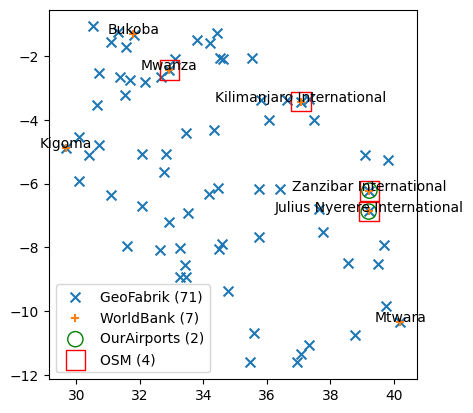

In [21]:
ax = gdf_geofabrik_a.plot(label=f"GeoFabrik ({len(gdf_geofabrik_a)})", marker='x', markersize=50)
gdf_worldbank.plot(ax=ax, label=f"WorldBank ({len(gdf_worldbank)})", marker='+', markersize=40)

for idx, row in gdf_worldbank.iterrows():
    plt.annotate(text=row['Name'], xy=(row['geometry'].x, row['geometry'].y),
                 horizontalalignment='center', size=10)

gdf_ourairports.plot(ax=ax, label=f"OurAirports ({len(gdf_ourairports)})", marker='o', facecolor='none', edgecolors='g',  markersize=120)

gdf_osm_int.plot(ax=ax, label=f"OSM ({len(gdf_osm_int)})",  marker='s', facecolor='none', edgecolors='r',  markersize=200)

ax.legend()

plt.show()

In [29]:
import leafmap.foliumap as leafmap
m = leafmap.Map(center=(40, -100), zoom=4)

m.add_gdf(gdf_geofabrik_a, layer_name="GeoFabrik")
m.add_gdf(gdf_osm_int, layer_name="OSM")
m

In [31]:
gdfosm = gdf_osm_int.copy()

In [33]:
gdfosm = gdfosm.dropna(axis=1,how='all')

,index,aeroway,name,source,geometry,nodes,ele,icao,wikidata,iata,...,name:cs,name:de,name:sk,ref,website,name:sw,wikipedia,loc_name,aerodrome,type
0,0,aerodrome,Kilimanjaro International Airport,NaN,POINT (37.07260 -3.42822),"[543472228, 7308329718, 7308329717, 543472233,...",890,HTKJ,Q1365099,JRO,...,Mezinárodní letiště Kilimandžáro,Flughafen Kilimandscharo International,Medzinárodné letisko Kilimandžáro,KIR,http://www.kilimanjaroairport.co.tz/,NaN,NaN,NaN,NaN,NaN
1,1,aerodrome,Abeid Amani Karume International Airport,NaN,POINT (39.22506 -6.22682),"[1489985158, 7262616671, 7262616672, 726261667...",NaN,HTZA,Q1393401,ZNZ,...,Mezinárodní letiště Abeida Amani Karumeho,NaN,NaN,NaN,NaN,Uwanja wa ndege wa Kimataifa wa Abeid Amani Ka...,en:Abeid Amani Karume International Airport,Zanzibar International Airport,NaN,NaN
2,2,aerodrome,Julius Nyerere International Airport,NaN,POINT (39.20707 -6.87360),"[252935666, 252935661, 252935660, 595149805, 5...",NaN,HTDA,Q1411192,DAR,...,NaN,NaN,NaN,NaN,NaN,NaN,en:Julius Nyerere International Airport,NaN,international,civil
3,3,aerodrome,Mwanza Airport,ourairports.com,POINT (32.93336 -2.44578),"[1896058533, 1896058531, 1896058530, 189605852...",NaN,HTMW,Q392790,MWZ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Germany for reference

In [178]:
df_worldbank = pd.read_csv('airport_volume_airport_locations.csv')
df_worldbank_ger = df_worldbank[df_worldbank['Country Name'] == "Germany"].sort_values('TotalSeats')

gdf_worldbank_ger = geopandas.GeoDataFrame(
    df_worldbank_ger, geometry = geopandas.points_from_xy(df_worldbank_ger.Airport1Longitude, df_worldbank_ger.Airport1Latitude))


In [179]:
dfx = df_ourairports[(df_ourairports['iso_country'] == 'DE') & (df_ourairports['type'] == 'large_airport')]

gdf_ourairports_ger = geopandas.GeoDataFrame(
    dfx, geometry = geopandas.points_from_xy(dfx.longitude_deg, dfx.latitude_deg))

In [174]:
ger = shapely.wkt.loads('MULTIPOLYGON (((8.407297932191138 55.04395228653645, 8.442500114441145 55.0159721374514, 8.353609085083235 54.967361450195654, 8.366944313049544 54.90236282348644, 8.429720878601302 54.87763977050787, 8.812039375305233 54.9167366027832, 9.224779129028263 54.85595321655279, 9.282591819763411 54.80223464965832, 9.408679962158317 54.841171264648494, 9.435277938842773 54.788471221923885, 9.613611221313704 54.87597274780296, 9.603055953979776 54.83152770996105, 9.84305572509794 54.756248474121094, 9.955279350281046 54.780139923095646, 10.034722328186263 54.67235946655285, 9.983054161071891 54.701248168945426, 9.963891689870369 54.67303628596345, 10.034166336059798 54.66986083984375, 10.02750015258789 54.55041503906284, 9.840277671813965 54.46736145019537, 10.199167251587141 54.45597076416027, 10.13194561004633 54.311248779296875, 10.228056907653865 54.413471221923885, 10.318612098693961 54.43569564819353, 10.704722404479924 54.304862976074276, 10.928610801696777 54.381805419922216, 11.128055572509766 54.39069366455084, 11.058609962463436 54.35430526733438, 11.093610763550032 54.19791793823248, 10.75416564941412 54.05486297607433, 10.890831947326603 53.955696105956974, 11.179167747497502 54.01569366455084, 11.258610725403116 53.98485946655296, 11.258610725403116 53.93402862548851, 11.335276603698844 53.95847320556646, 11.45472240447998 53.900417327881144, 11.483610153198242 53.968471527099666, 11.378055572509936 53.997360229492244, 11.492501258850325 54.02291488647472, 11.490279197693042 53.968193054199276, 11.62583255767845 54.08958435058588, 11.525277137756348 54.07180404663086, 11.682498931884766 54.15319442749018, 12.087498664856184 54.18319320678711, 12.124721527099894 54.150138854980526, 12.09527778625494 54.18097305297857, 12.339165687561263 54.2979164123538, 12.519721031188965 54.484306335449276, 12.962499618530387 54.437637329101676, 12.68351455577495 54.40644354068151, 12.715277671814022 54.404304504394474, 12.678054809570312 54.37014007568371, 12.786945343017862 54.3962516784668, 12.810278892517147 54.3451385498048, 13.019721984863338 54.43902587890659, 13.093609809875716 54.366806030273665, 13.105833053588867 54.281806945800895, 13.286388397216797 54.235137939453296, 13.346388816833723 54.18041610717819, 13.318054199219034 54.15986251831066, 13.415834426880224 54.17514038085943, 13.382498741150187 54.14236068725586, 13.456945419311523 54.090694427490234, 13.696389198303223 54.17180633544956, 13.806944847107104 54.10319519042969, 13.74416637420677 54.029304504394645, 13.914167404174805 53.92235946655302, 13.824722290039404 53.866249084473, 13.937500953674316 53.90847396850597, 13.90583419799816 53.98986053466797, 13.965278625488452 53.99013900756853, 13.959721565246582 53.93402862548851, 14.042499542236555 53.942081451416016, 14.046944618225268 53.99652862548845, 14.00347855685085 54.0366769060455, 14.221389770507926 53.93013763427729, 14.186329841613997 53.91558074951217, 14.2173366546632 53.865417480469205, 13.806388854980412 53.85819625854492, 14.038612365722884 53.75513839721674, 14.2830562591555 53.73875045776384, 14.215276718139592 53.70264053344738, 14.273162841796875 53.69930648803711, 14.324908256530762 53.61864852905296, 14.302708625793684 53.54261016845703, 14.448929786682186 53.26163864135748, 14.378918647766113 53.204158782958984, 14.345703125000057 53.052917480468864, 14.142452239990291 52.961112976074276, 14.121270179748649 52.84027099609369, 14.639061927795638 52.58003234863287, 14.600604057312069 52.53302383422857, 14.631249427795638 52.499130249023665, 14.528908729553166 52.39641189575218, 14.570899963378906 52.2895622253418, 14.699570655822868 52.24108886718756, 14.669348716736067 52.12155151367199, 14.741278648376522 52.07339096069347, 14.70477771759056 51.94266128540062, 14.586701393127385 51.823604583740234, 14.738728523254622 51.66687011718744, 14.698139190673942 51.55850982666027, 14.933858871460018 51.482269287109375, 14.967818260192928 51.3544158935548, 15.028479576110897 51.30979919433605, 14.930111885070744 50.99140548706072, 14.8050794601441 50.828918457031534, 14.710870742797965 50.826759338379134, 14.611928939819393 50.85478210449219, 14.651672363281364 50.93264007568365, 14.560112953186092 50.92348480224615, 14.595055580139274 50.988510131836165, 14.501680374145508 51.05150604248075, 14.39741039276123 51.00828170776373, 14.29401683807373 51.05416488647461, 14.246868133545036 50.97320175170904, 14.400946617126465 50.94234848022472, 14.372268676757926 50.88858032226568, 13.954609870910872 50.80371093750006, 13.850809097290096 50.71820068359375, 13.548975944519043 50.713214874267635, 13.465190887451229 50.59648895263689, 13.374910354614315 50.643661499023665, 13.326787948608512 50.581813812255916, 13.248618125915641 50.59226989746088, 13.195990562439079 50.500591278076286, 13.0332670211792 50.50854873657232, 12.977046012878645 50.41427230834961, 12.828769683837834 50.45862197875988, 12.705128669738826 50.39775848388672, 12.51611328125 50.40008544921898, 12.364088058471737 50.27642440795904, 12.32758998870844 50.17972946166998, 12.282715797424373 50.18267822265631, 12.194091796874943 50.32287597656256, 12.085860252380428 50.25535202026384, 12.198919296264876 50.19562149047863, 12.19906044006359 50.11182022094732, 12.256030082702637 50.062278747558594, 12.547736167907715 49.92714309692383, 12.472072601318473 49.79027175903349, 12.402890205383244 49.75516128540045, 12.527859687805176 49.68775939941435, 12.588051795959473 49.54399871826166, 12.645830154418945 49.53105926513672, 12.661074638366813 49.43216705322294, 12.78410530090332 49.35190582275402, 13.033589363098258 49.30863952636736, 13.180210113525618 49.144439697265625, 13.403729438781738 49.05178070068382, 13.401620864868221 48.98391342163103, 13.63125991821289 48.95058059692383, 13.835957527160701 48.7750511169433, 13.78705883026123 48.721511840820426, 13.809944152832088 48.590904235840014, 13.721092224121207 48.51679229736334, 13.503158569335938 48.59651184082037, 13.435749053955078 48.564682006835994, 13.410618782043514 48.377738952636776, 13.285719871520996 48.30517196655279, 12.868214607238826 48.20366668701183, 12.753028869628963 48.11729049682623, 13.00114727020275 47.8522300720216, 12.91126728057867 47.73124313354498, 13.043539047241325 47.720989227295206, 13.105588912963867 47.639202117920036, 13.013463973999023 47.46576690673845, 12.799818038940373 47.561462402343864, 12.826677322387695 47.61626052856451, 12.782772064209098 47.675922393799055, 12.605334281921444 47.67924880981457, 12.506064414978141 47.62885284423828, 12.43596267700218 47.70073318481451, 12.258779525756836 47.67621994018549, 12.254279136657772 47.739990234375114, 12.17435169219982 47.698875427246094, 12.2092800140382 47.60120010375982, 11.636343955993766 47.598270416259766, 11.58102035522461 47.51182174682634, 11.437379837036133 47.51325988769548, 11.388031959533805 47.47192382812523, 11.424080848693961 47.44562149047846, 11.341606140136776 47.45182418823248, 11.27390003204357 47.391010284423885, 11.224139213562012 47.391269683837834, 11.246058464050293 47.43478012084961, 10.977520942687931 47.39611053466808, 10.926508903503532 47.478080749511776, 10.862998962402344 47.47803115844738, 10.91859436035162 47.51609420776373, 10.883132934570426 47.53810501098644, 10.772025108337402 47.516143798828125, 10.600060462951888 47.57365036010742, 10.561381340026912 47.53593063354498, 10.432245254516829 47.58555984497076, 10.471569061279524 47.43306350708008, 10.433580398559798 47.378719329833984, 10.170168876648177 47.26990127563522, 10.226869583130338 47.3929176330567, 10.095960617065373 47.3548698425293, 10.090755462646598 47.45659255981451, 9.997338294983138 47.48622512817394, 9.971186637878759 47.55048370361328, 9.87366962432867 47.53071975708008, 9.774218559265364 47.59680175781267, 9.688732147217138 47.543983459472656, 9.044014930725098 47.82368850708008, 9.221139907837028 47.66815185546875, 9.164094924927213 47.65358352661133, 8.99164009094244 47.747985839844034, 8.941365242004451 47.731822967529354, 9.006369590759277 47.69509124755882, 8.891834259033374 47.65522384643566, 8.808216094970987 47.74168014526367, 8.771158218383846 47.71976852416992, 8.79814815521263 47.67990875244152, 8.727890014648608 47.696842193603686, 8.730445861816634 47.766109466552734, 8.56799125671381 47.8143768310548, 8.404397964477653 47.680049896240405, 8.473678588867188 47.64335632324219, 8.607149124145621 47.675994873046875, 8.584686279296875 47.60031127929693, 8.520914077758846 47.63809585571306, 8.458548545837402 47.60595703125017, 8.488503456115836 47.581394195556754, 8.379540443420467 47.570251464843864, 8.202873229980526 47.62615585327154, 8.087834358215446 47.56288528442394, 7.944071769714355 47.549701690673885, 7.820772171020621 47.5946998596192, 7.669493198394889 47.53711700439453, 7.632383823394775 47.5624237060548, 7.670560836792106 47.59326171875006, 7.607770919799862 47.580959320068416, 7.512126922607479 47.696090698242244, 7.62215709686285 47.97365951538109, 7.568590164184684 48.0363388061524, 7.577859401702995 48.121391296386776, 7.745231628417969 48.32982635498047, 7.733546733856315 48.39868545532238, 7.835922718048039 48.63367462158203, 8.087015151977653 48.802013397217024, 8.22887897491455 48.97063064575218, 7.937040328979435 49.05623245239258, 7.635286331176815 49.05416870117199, 7.445586204528809 49.184024810791016, 7.293400287628174 49.115158081054744, 7.098150730133057 49.15433120727545, 7.05802440643356 49.112586975097656, 7.033706188201904 49.18826293945324, 6.924295425415494 49.223075866699276, 6.840444087982178 49.21423339843767, 6.834462642669791 49.15137863159214, 6.737987518310831 49.16456985473633, 6.53541898727417 49.434162139892635, 6.35482120513916 49.46498489379883, 6.363647937774658 49.57404708862322, 6.516485214233398 49.724178314208984, 6.528252124786377 49.808570861816406, 6.312281131744612 49.83549880981457, 6.098370075225944 50.05990982055687, 6.189638137817383 50.189464569091854, 6.170382022857893 50.23625564575207, 6.408339977264632 50.33306884765619, 6.33975791931158 50.37989425659174, 6.374671936035213 50.44594955444336, 6.330028057098446 50.49364471435558, 6.172194004059065 50.55051422119158, 6.278378963470516 50.61639785766596, 6.173087120056209 50.62143325805687, 6.118731975555477 50.708736419677905, 5.963199138641357 50.79505157470703, 6.0738401412965 50.846858978271484, 6.082940101623649 50.921798706054744, 6.015170097351074 50.93315887451172, 6.030001163482893 50.98336410522472, 5.903690814971924 50.978271484375284, 5.872058868408317 51.04341125488281, 5.969543933868522 51.034469604492415, 6.171799182891846 51.15293121337896, 6.144780158996809 51.17371749877941, 6.193139076233138 51.19166183471674, 6.091834068298397 51.175292968750284, 6.078186035156193 51.2447128295899, 6.231968879699764 51.36598205566412, 6.220355987548942 51.50917053222656, 6.090958118438778 51.605220794677734, 6.118769168853703 51.6604576110841, 5.964007854461727 51.74161148071289, 6.004777908325309 51.76816940307623, 5.964649200439453 51.824409484863395, 6.168982028961295 51.84503173828142, 6.107149124145565 51.88898849487299, 6.158889770507812 51.905384063720646, 6.417467117309798 51.82563400268566, 6.402299880981388 51.87480163574219, 6.742709159851131 51.89905166625988, 6.835361003875846 51.99552917480486, 6.698178768157959 52.040119171142805, 6.700688838958968 52.07379150390648, 7.069309234619254 52.23925399780296, 7.029718875884953 52.29431915283209, 7.07911586761486 52.38272476196295, 7.006279945373649 52.469501495361385, 6.950539112091064 52.43696975708002, 6.764862060546875 52.464931488037166, 6.683791160583496 52.55606460571312, 6.768260955810604 52.56516647338867, 6.724298000335807 52.59061050415045, 6.743810176849422 52.64709091186529, 7.051859855651912 52.63584899902344, 7.094276905059871 52.84645080566429, 7.26148796081543 52.997539520263615, 7.226968765258846 53.124462127685604, 7.284560203552189 53.19956970214872, 7.205277919769514 53.23880767822271, 7.249166965484562 53.32986068725586, 6.998610973358154 53.361251831054915, 7.034166812896729 53.53319549560558, 7.13361120223999 53.53236007690424, 7.09027719497675 53.57652664184576, 7.158053874969539 53.627918243408146, 7.316944122314794 53.683471679687614, 8.015831947326944 53.71069335937506, 8.172499656677246 53.554584503173885, 8.155276298523177 53.513748168945426, 8.06472206115734 53.50597381591797, 8.073611259460677 53.46486282348633, 8.252499580383244 53.399028778076115, 8.316389083862418 53.46625137329124, 8.316389083862418 53.5220832824707, 8.230832099914778 53.52041625976574, 8.271943092346419 53.609859466552734, 8.516389846801701 53.55625152587902, 8.556944847106877 53.52569580078131, 8.519721984863338 53.50097274780279, 8.570834159851074 53.51819610595703, 8.483611106872786 53.69430541992193, 8.608056068420467 53.87874984741228, 8.883610725402946 53.82791519165045, 9.09972286224371 53.86291503906256, 8.963610649109114 53.894584655761776, 8.819722175598258 54.02152633666998, 8.98250007629423 54.04652786254911, 8.927499771118164 54.131805419921875, 8.85916709899908 54.12263870239269, 8.807498931884709 54.173194885253906, 8.83583259582548 54.251804351806584, 8.951944351196516 54.31289291381836, 8.846387863159237 54.26291656494169, 8.580278396606559 54.30402755737316, 8.60416603088413 54.357917785644645, 8.685832023620605 54.35708236694347, 8.608610153198185 54.38624954223644, 8.893611907959212 54.41208267211914, 9.02361106872587 54.472637176513786, 8.989167213440396 54.519306182861385, 8.903610229492188 54.46069335937506, 8.806388854980526 54.47041702270508, 8.890276908874682 54.59263992309582, 8.813055992126749 54.597362518311, 8.822500228881836 54.64597320556675, 8.687498092651595 54.72986221313516, 8.590276718139762 54.885139465331974, 8.41638755798374 54.84708404541021, 8.310277938842887 54.874305725097656, 8.279722213745174 54.75180435180687, 8.298054695129508 54.909305572509766, 8.407297932191138 55.04395228653645), (12.645990473625632 54.40224791003495, 12.435832977295036 54.378749847412166, 12.363612174987793 54.26597213745117, 12.460276603699072 54.24847412109369, 12.409167289733887 54.27986145019537, 12.645990473625632 54.40224791003495), (9.941296802167107 54.63977103947349, 9.933056831359806 54.627639770507926, 9.859076590154903 54.5913954629662, 9.938055038452319 54.62347412109392, 9.941296802167107 54.63977103947349), (9.740505208965892 54.53330511971416, 9.7124996185305 54.519584655761946, 9.545277595520133 54.5093040466308, 9.574166297912711 54.475139617920036, 9.624165534973372 54.51152801513672, 9.714722633362271 54.49124908447277, 9.740505208965892 54.53330511971416)), ((13.94762775222483 54.063982999902095, 13.910832405090275 54.064304351806754, 13.862501144409407 53.99930572509771, 13.858055114746207 54.04847335815441, 13.7691659927371 54.01902770996128, 13.812499046325684 54.09902954101568, 13.749167442322118 54.159027099609716, 13.803610801696834 54.17847061157232, 13.870834350586051 54.10152816772478, 13.94762775222483 54.063982999902095)), ((8.411785232872631 55.04948306636195, 8.417499542236328 55.05652618408209, 8.463055610656681 55.04569625854492, 8.411785232872631 55.04948306636195)), ((13.406170966791661 54.596560494420075, 13.3702783584597 54.61458206176752, 13.243055343628384 54.55875015258789, 13.2830562591555 54.64625167846674, 13.160833358764933 54.55902862548828, 13.249724388122615 54.659862518310945, 13.42916679382347 54.68458175659174, 13.37583255767845 54.63513946533203, 13.406170966791661 54.596560494420075)), ((13.446298879365024 54.57641239394589, 13.679720878601302 54.56263732910156, 13.569721221924112 54.46180725097662, 13.76694393157959 54.34152603149454, 13.72527885437006 54.27347183227545, 13.646389007568416 54.296527862548885, 13.70416736602806 54.326248168945426, 13.610832214355753 54.31624984741222, 13.68305587768566 54.34930419921881, 13.58083438873291 54.35291671752947, 13.352499008178768 54.26958465576217, 13.41805553436285 54.25485992431646, 13.393610000610408 54.22097396850586, 13.290279388427791 54.25125122070318, 13.335277557373274 54.278194427490234, 13.139166831970158 54.2823600769043, 13.18472290039091 54.30097198486328, 13.114721298217717 54.331806182861555, 13.127499580383471 54.37125015258789, 13.261943817138842 54.38291549682657, 13.149722099304313 54.42902755737305, 13.26805686950695 54.47930526733427, 13.158611297607422 54.504028320312614, 13.143611907959041 54.54680633544922, 13.305277824402083 54.51402664184582, 13.29749870300293 54.55236053466797, 13.368612289428881 54.57930374145502, 13.338055610656681 54.54875183105469, 13.377498626709098 54.55902862548828, 13.413056373596476 54.49375152587885, 13.506387710571403 54.480972290039006, 13.501943588257006 54.548473358154695, 13.446298879365024 54.57641239394589)), ((13.184166908264217 54.49430465698282, 13.226943969726733 54.468750000000114, 13.120834350586222 54.44235992431646, 13.184166908264217 54.49430465698282)), ((13.125168920038526 54.58240134124839, 13.13638877868675 54.6051406860351, 13.158054351806868 54.57930374145502, 13.125168920038526 54.58240134124839)), ((11.069721221924055 54.53470230102539, 11.23416805267334 54.5068054199221, 11.31360912322998 54.402084350586335, 11.00916671752924 54.44124984741211, 11.069721221924055 54.53470230102539)), ((8.691945075988713 54.557083129882756, 8.671944618225154 54.49458312988281, 8.589166641235579 54.51180648803711, 8.691945075988713 54.557083129882756)), ((8.539723396301383 54.75569534301769, 8.595276832580623 54.71958160400385, 8.56694316864025 54.6798629760745, 8.396944999694881 54.70569610595703, 8.539723396301383 54.75569534301769)), ((8.551387786865234 54.57958221435541, 8.573056221008358 54.55875015258789, 8.50916671752941 54.57402801513683, 8.551387786865234 54.57958221435541)), ((8.476387977600098 54.47652816772461, 8.52583217620861 54.433471679687614, 8.470277786254883 54.42180633544933, 8.476387977600098 54.47652816772461)), ((8.483055114746321 54.58458328247116, 8.501387596130428 54.55819320678711, 8.455277442932186 54.55875015258789, 8.483055114746321 54.58458328247116)), ((8.356944084167594 54.71152877807617, 8.395278930664062 54.61208343505899, 8.292498588561955 54.66708374023466, 8.356944084167594 54.71152877807617)), ((7.895833015442065 53.79402923584007, 7.968054771423567 53.774860382080305, 7.846387863159464 53.78680419921881, 7.895833015442065 53.79402923584007)), ((7.706388950348241 53.77958297729492, 7.805832862854288 53.774581909179744, 7.666944026947249 53.7587509155274, 7.706388950348241 53.77958297729492)), ((7.573610782623518 53.757362365722656, 7.627499103546597 53.74847412109381, 7.467502117157153 53.727085113525504, 7.573610782623518 53.757362365722656)), ((7.394165992737044 53.73458480834961, 7.429722785949707 53.725139617920206, 7.360278129577864 53.72680664062494, 7.394165992737044 53.73458480834961)), ((7.058610916137638 53.68458175659197, 7.095833778381348 53.680694580078125, 6.854722023010595 53.66125106811535, 7.058610916137638 53.68458175659197)), ((6.761944770812988 53.61875152587896, 6.811388969421671 53.60263824462885, 6.721387863159407 53.583751678466854, 6.749722003937052 53.55680465698242, 6.630833148956526 53.59791564941406, 6.761944770812988 53.61875152587896)))')

In [46]:
gdf_ger = ox.geometries_from_polygon(
    ger,
    {
        'aeroway': "aerodrome",
        'aerodrome': 'international',
        'aerodrome:type': 'international'
    }
)

In [181]:
gdf_ger_filter = gdf_ger[gdf_ger['aerodrome:type'].str.contains('international', na=False, regex=False) | 
                         (gdf_ger['aerodrome'] == 'international')]

gdf_ger_filter = gdf_ger_filter.reset_index(drop=True) # flatten MultiIndex
gdf_ger_filter['geometry'] = gdf_ger_filter['geometry'].to_crs('+proj=cea').centroid.to_crs(gdf_ger_filter.crs)


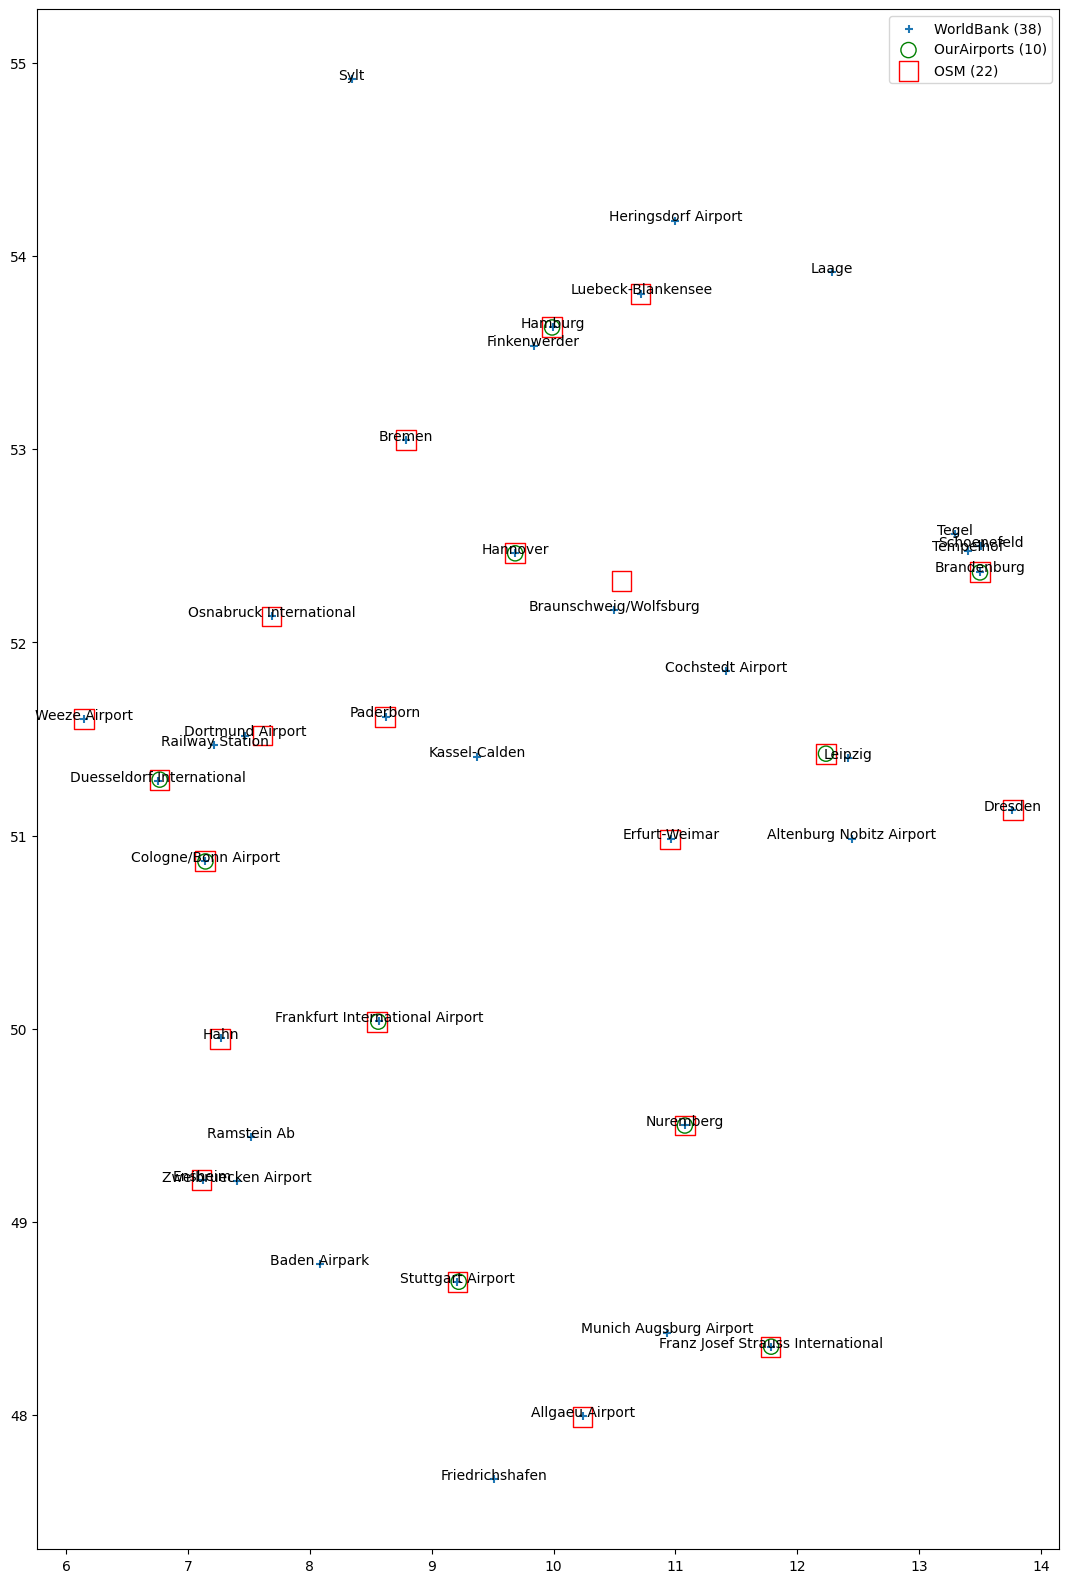

In [196]:
ax = gdf_worldbank_ger.plot(label=f"WorldBank ({len(gdf_worldbank_ger)})", marker='+', markersize=40, figsize=(20, 20))


for idx, row in gdf_worldbank_ger.iterrows():
    plt.annotate(text=row['Name'], xy=(row['geometry'].x, row['geometry'].y),
                 horizontalalignment='center', size=10)

gdf_ourairports_ger.plot(ax=ax, label=f"OurAirports ({len(gdf_ourairports_ger)})", marker='o', facecolor='none', edgecolors='g',  markersize=120)

gdf_ger_filter.plot(ax=ax, label=f"OSM ({len(gdf_ger_filter)})",  marker='s', facecolor='none', edgecolors='r',  markersize=200)

ax.legend()

plt.show()